# Simulating non-proteins and assigning charges to large molecules

We don't want you to get the impression that OpenFF only handles protein-ligand simulations. In fact, our force fields are trained to small molecule physical properties - for example part of the training of Sage was making sure it could reproduce experimental densities of organic mixtures. To show the versatility of our force fields, the following example will simulate [a "host-guest" system from the SAMPL6 challenge](https://github.com/samplchallenges/SAMPL6/tree/master/host_guest). 

In [1]:
from openff.toolkit import Topology, Molecule, ForceField
from openff.toolkit.utils._nagl_wrapper import _NAGLToolkitWrapper
from viz import visualize_topology
from pdbfixer import PDBFixer
import openmm
import openmm.unit as openmm_unit
from openff.interchange.components._packmol import pack_box
import nglview

host = Molecule.from_file('../sdf/CB8.sdf')
guest = Molecule.from_file('../sdf/CB8-G0.sdf')
top = Topology.from_molecules([host, guest])
top.to_file("complex.pdb")
nglview.show_file("complex.pdb")

NGLWidget()

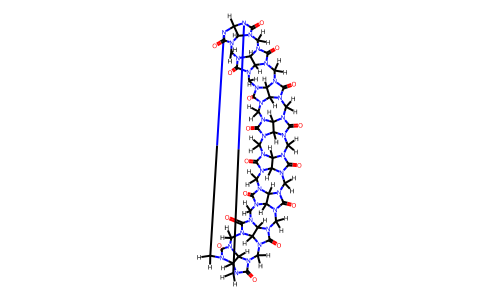

In [2]:
host.visualize(backend="rdkit")

Here we'll use OpenMM's "PDBFixer" tool to add a box of water and ions. There are many other open source software tools for doing this, including AMBER's `tleap`, GROMACS' `gmx solvate`, and PackMol. We're just using PDBFixer here because it's convenient and we don't have to leave the notebook.

In [3]:
fixer = PDBFixer("complex.pdb")
fixer.addSolvent(
    padding=1.0 * openmm_unit.nanometer, ionicStrength=0.5 * openmm_unit.molar
)

with open("complex_solvated.pdb", "w") as f:
    openmm.app.PDBFile.writeFile(fixer.topology, fixer.positions, f)

top = Topology.from_pdb("complex_solvated.pdb", unique_molecules=[host, guest])
visualize_topology(top)

NGLWidget()

OpenFF's mainline force fields currently use a semi-empirical (read: "fast and dirty") QM method to assign partial charges, called "AM1BCC". While this method gives surprisingly good accuracy for its computational cost, said cost scales worse than quadratically with molecule size. So AM1BCC will fail (or run for days) on the "host" in this complex, due to the large number of atoms.

Thankfully, OpenFF is jumping on the ML bandwagon. We're very close to publishing a graph neural network called "NAGL", which we've trained to produce AM1BCC charges. NAGL is very fast, typically running in less than a second. 

Here, we'll use NAGL to assign partial charges to the host and guest molecules.

In [4]:
nagl_tkw = _NAGLToolkitWrapper()
nagl_tkw.assign_partial_charges(host, "_nagl_am1bccelf10")
nagl_tkw.assign_partial_charges(guest, "_nagl_am1bccelf10")
print(host.partial_charges)

[-0.6201724475249648 0.828973107971251 -0.49292568024247885 0.21966723445802927 0.2757419878616929 -0.49292568024247885 0.2196671301499009 0.828973107971251 -0.6201724475249648 -0.49292568024247885 0.21966721955686808 0.27574189845472574 -0.49292568024247885 0.2196671748533845 0.8289731675758958 -0.6201724475249648 -0.49292568024247885 0.21966726426035166 0.2757419878616929 -0.49292568024247885 0.2196671897545457 0.828973107971251 -0.6201724475249648 -0.49292568024247885 0.2196671599522233 0.2757419580593705 -0.49292568024247885 0.21966723445802927 0.8289731675758958 -0.6201724475249648 -0.49292568024247885 0.21966720465570688 0.2757420176640153 -0.49292568024247885 0.2196671897545457 0.828973107971251 -0.6201724475249648 -0.49292568024247885 0.2196671599522233 0.2757419580593705 -0.49292568024247885 0.21966720465570688 0.8289731675758958 -0.6201724475249648 -0.49292562063783407 0.2196671748533845 0.2757420176640153 -0.49292568024247885 0.2196671897545457 0.828973107971251 -0.620172447

Now we create the simulation system. This is the step where charges get assigned. To force the simulation to use the NAGL charges we just generated instead of recalculating everything with "expensive" AM1BCC, we use the `charge_from_molecules` keyword argument. 

In [5]:
ff = ForceField("openff-2.1.0.offxml")
interchange = ff.create_interchange(top, charge_from_molecules=[host,guest])
sys = interchange.to_openmm()

Finally, we run and visualize the simulation using some boilerplate code. This is the "quick and dirty" version of how to run a simulation. In a real workflow, you'd want to equilibrate the temperature and pressure to make sure things are at the right density and are stable. 

In [6]:
import openmm
from openff.units import Quantity, unit
from openmm import unit as openmm_unit

# Construct and configure a Langevin integrator at 300 K with an appropriate friction constant and time-step
integrator = openmm.LangevinIntegrator(
    300 * openmm_unit.kelvin,
    1 / openmm_unit.picosecond,
    0.002 * openmm_unit.picoseconds,
)

# Combine the topology, system, integrator and initial positions into a simulation
simulation = openmm.app.Simulation(top.to_openmm(), sys, integrator)
simulation.context.setPositions(top.get_positions().to_openmm())
simulation.minimizeEnergy()

# Add a reporter to record the structure every 10 steps
dcd_reporter = openmm.app.DCDReporter("trajectory.dcd", 250)
simulation.reporters.append(dcd_reporter)
simulation.context.setVelocitiesToTemperature(300 * openmm_unit.kelvin)
simulation.runForClockTime(30 * openmm_unit.second)

In [7]:
import mdtraj
import nglview

trajectory: mdtraj.Trajectory = mdtraj.load(
    "trajectory.dcd", top=mdtraj.Topology.from_openmm(top.to_openmm())
)

view = nglview.show_mdtraj(trajectory.image_molecules())
view.add_representation("line", selection="water")
#view.add_representation(
#    "hyperball", radiusSize=1, radiusScale=0.5, selection="not protein and not water"
#)
view

NGLWidget(max_frame=34)